# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [43]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [44]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [45]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [46]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    # Місце для вашого коду
    self.layer_1 = DenseLayer(num_features, n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    # Місце для вашого коду
    self.layer_2 = DenseLayer(n_hidden_1, n_hidden_2)
    # Вихідний шар
    # Місце для вашого коду
    self.out_layer = DenseLayer(n_hidden_2, num_classes)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    # Місце для вашого коду
    x = self.layer_1(x, activation=0)
    x = self.layer_2(x, activation=0)
    x = self.out_layer(x, activation=1)

    return x

In [47]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Місце для вашого коду
    corr_pred = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(corr_pred, tf.float32))

In [48]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    # Місце для вашого коду
    trainable_variables = neural_net.trainable_variables

    # Обчислимо за ними значення градієнта
    # Місце для вашого коду
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    # Місце для вашого коду
    optimizer.apply_gradients(zip(gradients, trainable_variables))



In [49]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    # Місце для вашого коду
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        # Місце для вашого коду
        loss = cross_entropy(pred, batch_y)
        loss_history.append(loss)
        current_accuracy = accuracy(pred, batch_y)
        accuracy_history.append(current_accuracy)
        print(f"Step: {step}, loss: {loss:.4f}, accuracy: {current_accuracy:.4f}")


Step: 100, loss: 267.5431, accuracy: 0.7148
Step: 200, loss: 199.7326, accuracy: 0.7539
Step: 300, loss: 134.6709, accuracy: 0.8320
Step: 400, loss: 123.7644, accuracy: 0.8398
Step: 500, loss: 156.1423, accuracy: 0.8516
Step: 600, loss: 150.5379, accuracy: 0.8203
Step: 700, loss: 98.6633, accuracy: 0.8828
Step: 800, loss: 123.4029, accuracy: 0.8320
Step: 900, loss: 89.9186, accuracy: 0.8906
Step: 1000, loss: 95.1194, accuracy: 0.8750
Step: 1100, loss: 107.4796, accuracy: 0.8555
Step: 1200, loss: 110.5479, accuracy: 0.9023
Step: 1300, loss: 81.3642, accuracy: 0.9180
Step: 1400, loss: 68.6207, accuracy: 0.8945
Step: 1500, loss: 74.7129, accuracy: 0.8906
Step: 1600, loss: 62.5813, accuracy: 0.9414
Step: 1700, loss: 83.4081, accuracy: 0.8867
Step: 1800, loss: 79.8832, accuracy: 0.9141
Step: 1900, loss: 78.6201, accuracy: 0.9336
Step: 2000, loss: 91.9202, accuracy: 0.9023
Step: 2100, loss: 97.4036, accuracy: 0.8984
Step: 2200, loss: 74.1890, accuracy: 0.9180
Step: 2300, loss: 82.2215, accur

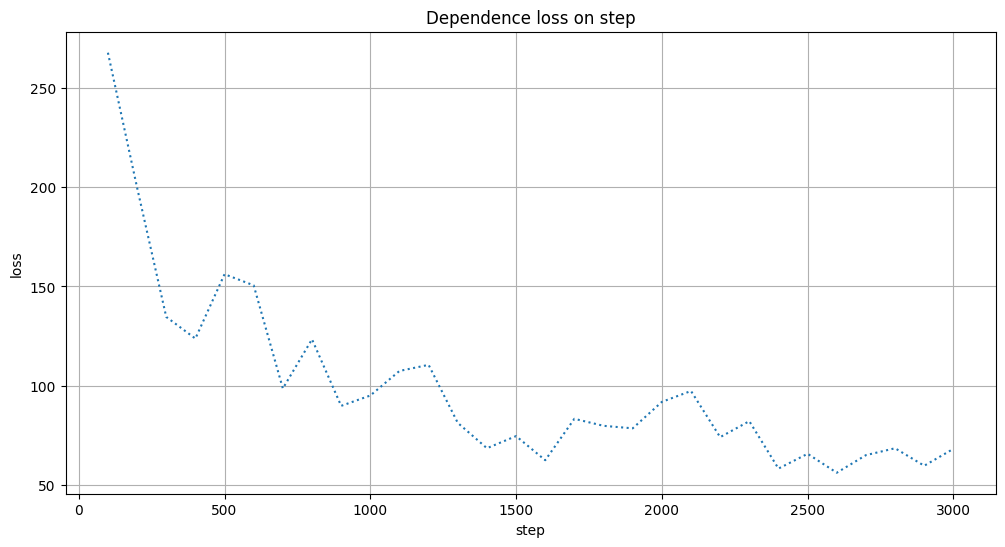

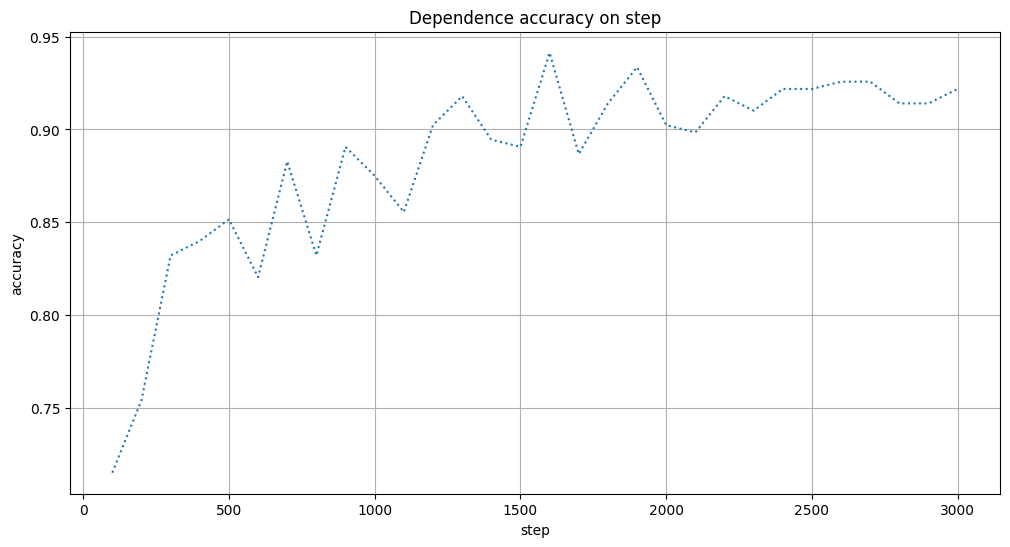

In [50]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt
def show_plt(history, name):
    plt.figure(figsize=(12,6))
    plt.plot(range(100, 3001, 100), history, linestyle=":")
    plt.title(f'Dependence {name} on step')
    plt.xlabel('step')
    plt.ylabel(f'{name}')
    plt.grid(True)
    plt.show()

# Виведіть графік функції втрат
# Місце для вашого коду
show_plt(loss_history, "loss")

# Виведіть графік точності
# Місце для вашого коду
show_plt(accuracy_history, "accuracy")


Neural Net Accuracy: 0.9237833619117737
Тестова цифра: 9
Мережа передбачила цифру 9
Зображення цифри


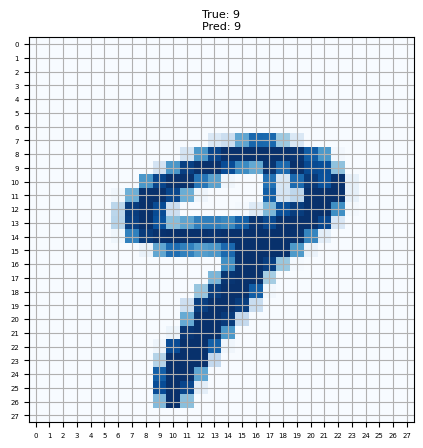

In [51]:
# Обчисліть точність навченої нейромережі
# Місце для вашого коду
accuracy_neural_net = accuracy(neural_net(x_train), y_train)
print(f"Neural Net Accuracy: {accuracy_neural_net}")








# Тестування моделі на тестових даних
# Місце для вашого коду
idx_of_some_digit = 9
test_image = x_test[idx_of_some_digit].reshape(1, -1)
test_digit = y_test[idx_of_some_digit]

print(f'Тестова цифра: {test_digit}')

# Прогнозуємо йовірності вибраних зображень
p_pred = neural_net(test_image)

# Виводимо індекс компоненти, яка має найбільше значення
y_pred = p_pred[0].numpy()
predicted_digit = y_pred.argmax()

print(f'Мережа передбачила цифру {predicted_digit}')

print(f'Зображення цифри')

plt.figure(figsize=(5, 5))
plt.xticks(range(0, 28, 1), fontsize=5)
plt.yticks(range(0, 28, 1), fontsize=5)
plt.imshow(test_image[0].reshape((28, 28)), cmap='Blues')
plt.title(f"True: {test_digit}\nPred: {predicted_digit}", fontsize=8)
plt.grid()
plt.show()

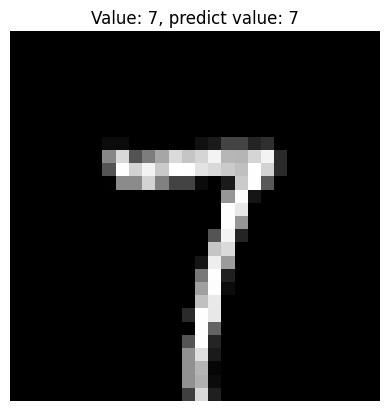

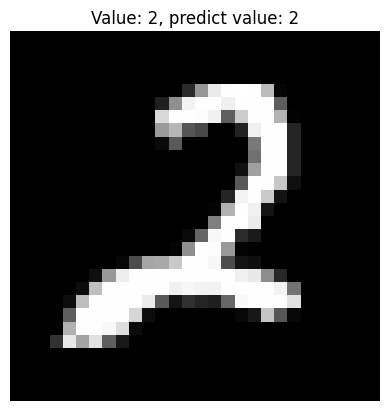

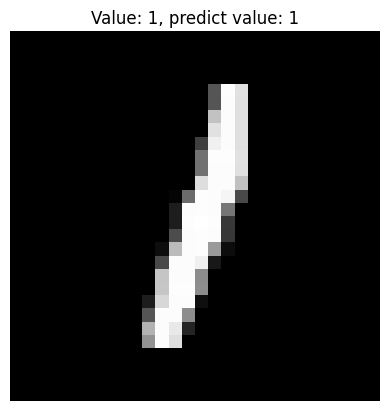

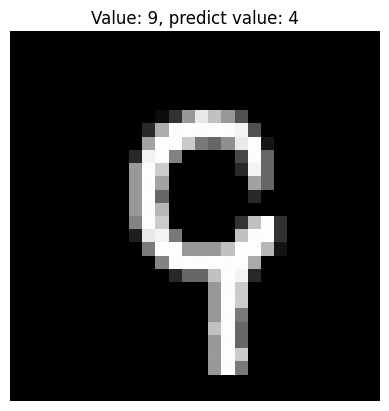

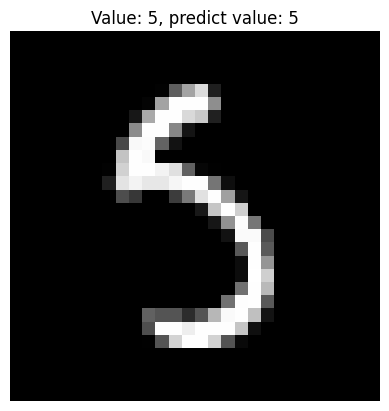

Precision of the trained neural network: 80.0%


In [52]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Місце для вашого коду
images_number = 5
random_indices = random.sample(range(len(x_test)), images_number)
test_img = x_test[random_indices]
test_values = y_test[random_indices]

predict = neural_net(test_img)
predict_values = tf.argmax(predict, axis=1)

count_img = 0

for i in range(len(test_img)):
    image = test_img[i].reshape((28, 28))
    value = test_values[i]
    predict_value = predict_values[i]
    if predict_value == value:
      x = 100/images_number
      count_img += x
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(f"Value: {value}, predict value: {predict_value}")
    plt.show()

print(f'Precision of the trained neural network: {count_img}%')



#Висновки

Нейромережа працює добре у відповідності до визначеної якості, а саме до рівня точності визначеної у 90%.
Тестуючи нейромережу декілька разів зафіксовані випадки більшої кількості помилок, це відбувається коли тестові цифри схожі одна на одну і рівень точності становить на рівні 80-85%.